# Mejora tus modelos

En este notebook vamos a ver diferentes técnicas para mejorar nuestros modelos y optimizar el proceso de entrenamiento. La mayoría de estas técnicas son útiles para modelos tanto de regresión como de clasificación, aunque no todas tiene sentido en ambas.

 - Análisis de multicolinealidad
 - Validación cruzada o Cross-Validation
 - Regularización y optimización
 - Selecciona los mejores parámetros de tu modelo usando Grid Search
 - Categorización de variables continuas usando Weight of Evidence (WOE)
 - Entrena tu modelo paso a paso usando una función stepwise
 - Curva ROC
 - Selección de punto de corte (Threshold)
 


## Preparación datos para ejemplos

Tenemos datos de breast-cancer, con una serie de medidas de lunares y marcas en la piel, y una variable dependiente de Maligno/Benigno.



In [5]:
# !pip install optbinning
# !pip install mlxtend

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score, GridSearchCV
# !pip install scikit-learn==0.20.0
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_curve, roc_auc_score, r2_score
# from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from statsmodels.stats.outliers_influence import variance_inflation_factor

#!pip install builder
from optbinning import BinningProcess, OptimalBinning # Para cáclulos WOE e IV

from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

In [10]:
# !pip install protobuf==3.20.3

In [12]:
cancer = pd.read_csv('../../../Data/Modelos ML/breast-cancer.csv', sep = ';')
diagnosis={'M': 1, 'B': 0} 

def encode(dic, x):   
    return dic[x]    

cancer['diagnosis2']=cancer['diagnosis'].apply(lambda x: diagnosis[x])
cancer.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis2
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1


In [13]:
X = cancer.drop(columns=['id','diagnosis', 'diagnosis2'])
X = cancer[['smoothness_mean','compactness_mean']]
y = cancer['diagnosis2']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state=42)

# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)


## Análisis de multicolinealidad

La alta colinealidad (o multicolinealidad) ocurre cuando dos o más variables explicativas están altamente correlacionadas entre sí. Esto puede tener efectos negativos importantes, especialmente en **modelos lineales o donde la interpretabilidad es clave**.

### Consecuencias de la colinealidad

La alta colinealidad puede **dificultar la interpretación** de la magnitud de los coeficientes y su signo. Estadisticamente, la prueba T puede no considerar los coeficientes como significativos cuando sí lo son. Por lo tanto, si introducimos dos variables correlacionadas el modelo tiene dificultades para "culpar" a las variables de la predicción, dividiendo su importancia. Por un lado, puede que salgan del modelo por no ser consideradas significativas, y por otro no somos conscientes del impacto que puede tener `X1` en la variable dependiente.

En sectores como salud, banca o recursos humanos, se exige justificar por qué el modelo predice algo para que la entidad lo ponga en producción, si tus variables no son suficientemente interpretables puede que no te lo validen.

Los modelos que más sufren estas consecuencias son la regresión lineal y la logística. Por el contrario, los Random Forest y XGBoost son los más robustos. Sin embargo, estos últimos es muy difícil interpretarlos. 

### Cómo detectar multicolinealidad en variables continuas

A través de la matriz de **correlación** entre **variables continuas**. A partir de |0.8| podemos sospechar de alta colinealidad.

**VIF (Variance Inflation Factor)** Mide cuánta varianza del coeficiente se infla por colinealidad con las demás variables. 

$
\text{VIF}_j = \frac{1}{1 - R_j^2}
$

$R_j^2$: Coeficiente de determinación al **regresar la variable $j$** contra **todas las demás variables independientes**


Si VIF = 1 consideramos que no hay colinealidad; en torno a 5, existe multicolinealidad, pero es modelara. A partir de 10 es severa y debemos tomar acciones.


### Acciones a tomar

En caso de tener alta colinealidad entre variables podemos:

 - Eliminar aquellas variables correlacionadas, dejando siempre una para no perder esa información
 - Análisis de Componentes Principales, Este procedimiento crea una nueva variable que es combinación lineal de aquellas correlacionadas
 - Regularización, Lasso o Ridge
 - Cambiar a modelo más robustos a la colinealidad como Random Forest
 

In [17]:
X_VIF = cancer[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']]
vif_data = pd.DataFrame()
vif_data["variable"] = X_VIF.columns
vif_data["VIF"] = [variance_inflation_factor(X_VIF.values, i) for i in range(X_VIF.shape[1])]

vif_data

,variable,VIF
0,radius_mean,63306.172036
1,texture_mean,251.047108
2,perimeter_mean,58123.586079
3,area_mean,1287.262339
4,smoothness_mean,393.398166
5,compactness_mean,200.980354
6,concavity_mean,157.855046
7,concave points_mean,154.241268
8,symmetry_mean,184.426558
9,fractal_dimension_mean,629.679874


In [29]:
X_VIF = cancer[[ 
       'area_mean', 'smoothness_mean',
       'concave points_mean', 'symmetry_mean']]
vif_data = pd.DataFrame()
vif_data["variable"] = X_VIF.columns
vif_data["VIF"] = [variance_inflation_factor(X_VIF.values, i) for i in range(X_VIF.shape[1])]

vif_data

,variable,VIF
0,area_mean,11.408334
1,smoothness_mean,54.590054
2,concave points_mean,7.742159
3,symmetry_mean,53.728130


### Cómo detectar colinealidad en variables categóricas

Cramér’s V es una medida de asociación entre dos variables categóricas. Se basa en el estadístico chi-cuadrado y proporciona un valor normalizado entre 0 y 1:

$Cramér's V = \sqrt{(χ² / (n × (k - 1)))}$

Donde:

$χ²$: estadístico chi-cuadrado de la tabla de contingencia.

n: número total de observaciones.

k: el menor número de categorías entre las dos variables (mínimo de filas o columnas).

Cramér's V	| Asociación

0.0-0.20 --> Débil

0.20–0.40 --> Moderada

0.40–0.60 --> Fuerte

0.60-1 --> Muy fuerte

Esta función devuelve una matriz similar a la matriz de correlación para las variables categóricas a partir de la V de Cramer. La fuerza de la asociación es la indicada arriba, sin embargo no indica que sea significativa, para ello habría que realizar un test de hipótesis. Igualmente pasa con la correlaciónde pearson

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from itertools import combinations

def cramers_v_matrix(df):
    # Seleccionar solo columnas categóricas
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns
    result = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
    
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        if confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
            return np.nan  # Evitar divisiones por 0
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        return np.sqrt(phi2 / min(k - 1, r - 1))
    
    for var1, var2 in combinations(cat_cols, 2):
        v = cramers_v(df[var1], df[var2])
        result.loc[var1, var2] = v
        result.loc[var2, var1] = v
    
    np.fill_diagonal(result.values, 1.0)  # La diagonal es 1 (correlación perfecta consigo misma)
    return result


In [ ]:
cramers_v_matrix(df[['var_categorica1', 'var_categorica2', 'var_categorica3']])

## Validación Cruzada (Cross Validation)

https://1library.co/article/validaci%C3%B3n-cruzada-aprendizaje-por-retro-propagaci%C3%B3n-de-errores.zxnrp7oq

https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada


https://tech.gobetech.com/53557/como-se-aplica-la-validacion-cruzada-a-la-regresion-logistica-quiero-evaluar-la-precision-de-un-modelo-de-regresion-logistica-en-un-conjunto-de-datos.html#:~:text=El%20%C3%A1rea%20bajo%20la%20curva%20ROC%20es%20una,y%20odds%20ratio%20de%20una%20variable%20explicativa%20continua%29.

----------------

Es un método de **selección entre un modelo y otro**. Esta técnica es usada tanto en los modelos de clasificación como de regresión.

Se basa en **dividir el conjunto de entrenamiento en K partes**. Se van a hacer en total K iteraciones, en cada una de ellas vamos a entrenar el modelo con K-1 subpartes y la última será usada como validación.

La utilidad final de la valdiación cruzada es calcular K métricas (accuracy, MSE o la que más nos interese según nuestro problema) y **calcular la media de dichas métricas**. Este cálculo se realiza en 2 ó más **modelos que queramos comparar**, aquel modelo que tenga una mejor métrica será considerado mejor que el otro.

Cuando hablamos de dos modelos diferentes puede ser porque usemos un algoritmo diferente (Random Forest vs Regresión Logística) o el mismo algoritmo pero con diferentes variables independientes o con diferentes hiperparámetros (Número de árboles en el RF o regularización en la RL)

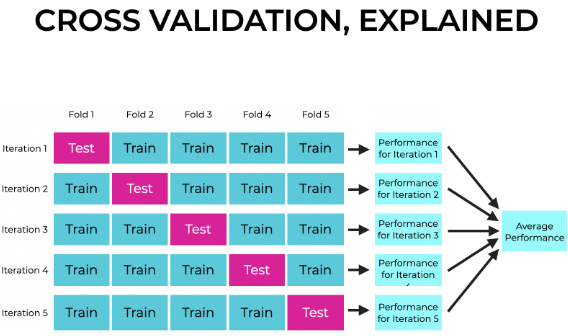



In [29]:
model_LR_rus = LogisticRegression()
model_LR_rus.fit(X_train_rus, y_train_rus)

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 5, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model_LR_rus, X_train_rus, y_train_rus, scoring='accuracy', cv=cv, n_jobs=-1)
acc_LR_mean = np.mean(n_scores).round(4) 
acc_LR_var = np.var(n_scores).round(4) 
print("accuracy media entre los 10 modelos:", acc_LR_mean)

accuracy media entre los 10 modelos: 0.7698


In [147]:
n_scores

array([0.89705882, 0.92647059, 0.97058824, 0.97014925, 0.95522388,
       0.97058824, 0.94117647, 0.97058824, 0.89552239, 0.94029851,
       0.95588235, 0.94117647, 0.91176471, 0.95522388, 0.94029851,
       0.95588235, 0.95588235, 0.92647059, 0.94029851, 0.94029851,
       0.91176471, 0.95588235, 0.94117647, 0.95522388, 0.95522388,
       1.        , 0.92647059, 0.91176471, 0.98507463, 0.92537313,
       0.97058824, 0.98529412, 0.89705882, 0.94029851, 0.94029851,
       0.92647059, 0.95588235, 0.95588235, 0.94029851, 0.97014925,
       0.89705882, 0.94117647, 0.97058824, 0.95522388, 0.92537313,
       0.95588235, 0.98529412, 0.88235294, 0.97014925, 0.94029851])

In [20]:
result_RF_rus = RandomForestClassifier(n_estimators = 16, criterion ='gini')   
result_RF_rus.fit(X_train_rus,y_train_rus)

result_RF_rus = result_RF_rus.fit(X_train_rus, y_train_rus)

# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(result_RF_rus, X_train_rus, y_train_rus, scoring='accuracy', cv=cv, n_jobs=-1)
acc_RF_mean = np.mean(n_scores).round(4) 
acc_RF_var = np.var(n_scores).round(4) 
print("accuracy media entre los 10 modelos:", acc_RF_mean)

accuracy media entre los 10 modelos: 0.9426


En este caso estamos comparando si la detección de lunar Maligno o Benigno es mejor hacerla con una regresión logística o con un random forest. Para ello hemos entrenado el modelo **5 veces con 5 subconjuntos de entrenamiento diferentes**.

Esos 5 entrenamientos han sido realizados con **4 subconjuntos de entrenamiento y 1 de validación**. Finalemente se han obtenido 5 accuracies por cada modelo. Hemos realizado la media y varianza de esas 5 estimaciones y ha resultado que el Random forest tiene una mayor exactitud en sus precisiones que la regresión logística.

De esta manera, sabemos que el Random Forest es mejor para determinar si las marcas en la piel son malignas o benignas que la Regresión Logística, y que esta decisión es más robusta, no se debe a casualidades a la hora de dividir el conjunto de entrnamiento y test.

El **conjunto de test** separado al inicio del entrenamiento del modelo, el que hemos estado usando hasta ahora seguirá cumpliendo la misma función, nos servirá para calcular la **matriz de confusión** (True Positive, True Negative...).

## Sesgo y Varianza de los modelos

Existen dos conceptos clave a la hora de validar modelos.

**El sesgo** mide cuánto se alejan en promedio las predicciones del modelo respecto a la realidad. Ocurre cuando un modelo es demasiado simple y no capta la realidad en los datos.

**La varianza** mide cuánto cambian las predicciones del modelo cuando cambian los datos de entrenamiento. Por ejemplo cuando el modelo se ajusta demasiado a los datos de entrenamiento.



<div style="display: flex; justify-content: space-between;">
  <img src="../../assets/variance_bias.png" alt="First Image" style="width: 35%;"/>
  <img src="../../assets/variance_bias2.png" alt="Second Image" style="width: 50%;"/>
</div>

## Loss function, Regularization & Optimization

### Lost Function

A loss function, a.k.a. cost function, is a mathematical function used in machine learning to measure the **difference between the predicted values and the actual target values**. The goal of a machine learning algorithm is to minimize this function during the training process.

The loss function quantifies the model's performance: the smaller the loss, the better the model's predictions align with the actual data. 

Different machine learning tasks (such as regression, classification, and clustering) require different types of loss functions. For example:

 - **Mean Squared Error (MSE)**: Commonly used for regression problems, it measures the average of the squared differences between predicted and actual values.
 
$$
{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

 - **Binary Cross-Entropy Loss**: Used in binary classification problems, particularly with logistic regression. It measures the difference between predicted probabilities and actual binary labels.
 
$$
\text{Cross-Entropy} = -\sum_{i=1}^{n} \left[ y_i \log(p_i) + (1 - y_i)\log(1 - p_i) \right]
$$

### How training occurs

During the training of machine learning models, the computer performs multiple iterations to adjust the model's parameters. At each iteration, the model calculates the loss function, which measures how far its predictions are from the actual values. Based on the result of the loss function, the model is assessed to determine whether it is optimized or if further iterations are needed. If the loss is high, adjustments are made, and the model undergoes more iterations. This process continues until the loss reaches an acceptable level, indicating that the model has learned the patterns in the data.

### Regularization

In machine learning, regularization is a technique used to prevent overfitting and improve the generalization of a model. 

**Overfitting** occurs when a model learns the training data too well, capturing noise and irrelevant patterns that don't generalize to new, unseen data.

Regularization methods **add a penalty term to the loss function at each iteration**, guiding the learning algorithm away from fitting the training data too precisely. By penalizing large coefficients, regularization encourages the model to remain simpler and more robust, improving its ability to generalize to unseen data.

Two common types of regularization are:

 - **L1 Regularization (Lasso)**: Adds the absolute values of the coefficients of features to the loss function. L1 regularization encourages sparsity, meaning it can lead to some feature coefficients becoming exactly zero. This is useful for feature selection.
 
 $$
\text{L1} = \lambda \sum_{j=1}^{p} |\beta_j|
$$

 - **L2 Regularization (Ridge)**: Adds the squares of the coefficients of features to the loss function. L2 regularization discourages large coefficients for any particular feature, making the model more stable and less sensitive to individual data points.
 
 $$
\text{L2} = \lambda \sum_{j=1}^{p} \beta_j^2
$$

The strength of regularization (often denoted by the term lambda or alpha) is a hyperparameter that needs to be tuned. Regularization helps in producing simpler models that generalize better to new, unseen data, especially when the training dataset is small or noisy.

### How to apply regularization

$$
{Loss_R} = {MSE} + {L1}
$$


### Benefits of Regularization

Till now, we have understood about the **Overfitting** and **Underfitting** techniques, but let's have an understanding of the benefits of regularization.

1. **Prevents Overfitting**: Regularization helps models focus on underlying patterns instead of memorizing noise in the training data.

2. **Improves Interpretability**: L1 (Lasso) regularization simplifies models by reducing less important feature coefficients to zero.

3. **Enhances Performance**: Prevents excessive weighting of outliers or irrelevant features, improving overall model accuracy.

4. **Stabilizes Models**: Reduces sensitivity to minor data changes, ensuring consistency across different data subsets.

5. **Prevents Complexity**: Keeps models from becoming too complex, which is crucial for limited or noisy data.

6. **Handles Multicollinearity**: Reduces the magnitudes of correlated coefficients, improving model stability.

7. **Allows Fine-Tuning**: Hyperparameters like alpha and lambda control regularization strength, balancing bias and variance.

8. **Promotes Consistency**: Ensures reliable performance across different datasets, reducing the risk of large performance shifts.





### Optimization

In regression, the solver refers to the optimization algorithm used to find the optimal coefficients (weights) for the  regression model. 

 - For small datasets, **‘liblinear’** is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;

 - For multiclass problems, only **‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’** handle multinomial loss;

 - **‘liblinear’** is limited to one-versus-rest schemes.

 - **‘newton-cholesky’** is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories. Note that it is limited to binary classification and the one-versus-rest reduction for multiclass classification. Be aware that the memory usage of this solver has a quadratic dependency on n_features because it explicitly computes the Hessian matrix.

The choice of solver depends on the dataset size, the number of features, and the specific logistic regression variant being used (e.g., L1 regularization, L2 regularization). 

Experimentation and validation are often necessary to determine the best-performing solver for a given logistic regression problem.





https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html




In [10]:
model_LR_rus = LogisticRegression(penalty = 'l2', solver = 'liblinear')
model_LR_rus.fit(X_train_rus, y_train_rus)

# define the model evaluation procedure
cross_val = RepeatedStratifiedKFold(n_splits=5, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model_LR_rus, X_train_rus, y_train_rus, scoring='accuracy', cv=cross_val)
acc_LR_mean_1 = np.mean(n_scores).round(4) 
acc_LR_var_1 = np.var(n_scores).round(4) 
print("average accuracy 5 models:", acc_LR_mean_1)

average accuracy 5 models: 0.9447


## Grid Search


Grid Search is a **hyperparameter tuning technique** in machine learning where a set of hyperparameters is specified, and the algorithm trains a model for every possible combination of these hyperparameters.

In `LogisitcRegression()`, `C` determines the strenght of the regularization

In [11]:
model_LR_rus = LogisticRegression()

cross_val = RepeatedStratifiedKFold(n_splits=5, random_state=1)

grid_values = {'penalty': ['l1','l2'], 'solver':['saga','liblinear'], 'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(model_LR_rus, param_grid = grid_values, scoring = 'accuracy', cv = cross_val)
grid.fit(X_train_rus, y_train_rus)
y_decision_fn_scores_re = grid.decision_function(X_test) 

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

print('Grid best parameter: ', grid.best_params_)
print('Grid best score: ', grid.best_score_)


Best: 0.944688 using {'penalty': 'l2', 'solver': 'liblinear'}
Grid best parameter:  {'penalty': 'l2', 'solver': 'liblinear'}
Grid best score:  0.9446883230904303


If we want to introduce **different models** in the grid search we can do it through a for loop

In [16]:
classifiers = {
    'LogisticRegression': (LogisticRegression(), {'penalty': ['l1','l2'], 'solver':['saga','liblinear']}),
    'RandomForestClassifier': (RandomForestClassifier(), {'max_depth': [None, 10, 20],'criterion':['gini','entropy']})
}

In [17]:
cross_val = RepeatedStratifiedKFold(n_splits=5, random_state=1)
results = {}
for clf_name, (clf, params) in classifiers.items():
    grid_search = GridSearchCV(clf, params, cv=cross_val, scoring = 'accuracy')
    grid_search.fit(X_train_rus, y_train_rus)
    results[clf_name] = {
        'Best Parameters': grid_search.best_params_,
        'Best Score': grid_search.best_score_
    }

In [18]:
for clf_name, result in results.items():
    print(f'Classifier: {clf_name}')
    print(f'Best Parameters: {result["Best Parameters"]}')
    print(f'Best Score: {result["Best Score"]}\n')

Classifier: LogisticRegression
Best Parameters: {'penalty': 'l2', 'solver': 'liblinear'}
Best Score: 0.9446883230904303

Classifier: RandomForestClassifier
Best Parameters: {'criterion': 'entropy', 'max_depth': 10}
Best Score: 0.9671246707638281



## Categorización de variables continuas usando Weight of Evidence (WOE)

### WOE (Weight of Evidence)
El **Weight of Evidence (WOE)** es una técnica utilizada en estadística y modelado predictivo, especialmente en crédito y análisis de riesgos. Mide la relación entre la proporción de "buenos" y "malos" en cada grupo de una variable categórica o binned (segmentada) para una variable numérica. Se calcula como:

$$
WOE = \ln\left( \frac{\% \text{ de buenos en el grupo}}{\% \text{ de malos en el grupo}} \right)
$$


### IV (Information Value)
El **Information Value (IV)** mide la capacidad predictiva de una variable independiente respecto a una variable objetivo binaria (por ejemplo, default/no default). Se basa en el WOE de cada grupo y se calcula como:


$$
IV = \sum \left( (\% \text{ buenos} - \% \text{ malos}) \times WOE \right)
$$



| Variable categorizada | count | Numero de bad | Numero de good | bad_rate | good_rate | WOE       | IV        |
|------------------|-------|-----|---------|----------|-----------|-----------|-----------|
| nivel alto        | 253   | 157 | 96      | 0.74 | 0.27  | -1.013045 | 0.477811  |
| nivel medio         | 163   | 43  | 120     | 0.20 | 0.33  | 0.505142  | 0.067337  |
| nivel bajo        | 153   | 12  | 141     | 0.05 | 0.4  | 1.942700  | 0.657320  |

## Cómo hacer uso de estas métricas para el entrenamiento de modelos

Estas dos métricas son ampliamente usadas en los **modelos de clasificación**, por ejemplo en riesgo de crédito. En donde tenemos una variable dependiente binaria, cliente bueno o malo.

El WOE vamos a usarlo para definir nuevas variables a partir de las continuas ya existentes. Por ejemplo del nivel de ingresos. A las observaciones situadas en cada "categoría" se les **imputará el valor correspondiente a su WOE**. Estas categorías serán optimizadas de manera a discriminar de la mejor manera posible la variable dependiente.

A pesar de que la **nueva variable tomará solo 3 ó 4 valores ésta será considerada continua**, es decir NO transformaremos a variables dummy. Esto es debido a que los nuevos valores sí tienen un orden. Además, tiene características de continua, por ejemplo la distancia entre un valor y otro cambia. No son 0, 1, 2, 3...; es -1.9, -0.5, 0.3, 2.18... Aunque sean igualmente 4 valores tienen un orden y de amplitudes distintas.

Importante recordar que estas transformaciones **se calculan usando el conjunto de datos de entrenamiento** y que se computan con la misma configuración en los datos de validación. NO se calculan WOEs diferentes para los datos de validación.

## Ventajas de hacer la transformación con el WOE

**Mejor interpretabilidad**: Nuestra variable continua original será más fácil de interpretar. Si es introducida en el modelo sin transformación, simplemente podremos saber que cuando toma valores bajos (o altos) es más propensa (o menos) a incurrir en la clase 1 de la variable dependiente binaria.

Con la nueva transformación sabremos más en detalle cómo de más o menos probable es que las observaciones con un nivel determinado en la variable continua independiente tome la clase 1 en la dependiente.

**Monotonía y estabilidad**: La monotonía, en el contexto de modelado predictivo y especialmente en binning o transformación de variables, se refiere a que la relación entre una variable independiente y la variable objetivo se mantiene en una sola dirección a lo largo de todos los valores (o bins).

Estabilidad temporal: reduce fluctuaciones en el sentido de que reduce/disuelve la no monotonía de una pequeña categoría con comportamiento extraño debido a outliers (por ejemplo).

**Convergencia en el entrenamiento**: Los Modelos lineales agradecen estas transformaciones ya que ayuda a que regresiones logísticas converjan mejor y hagan predicciones más consistentes.

## Ejemplo de transformación con WOE

Vamos a transformar "texture_mean" para prepararla antes de introducirla en el modelo.

Instalamos e importamos otpbinning. Esta librería nos va a calcular de manera automática los WOEs óptimos.

**El método BinningProcess** optimiza la definición de los WOEs. Tenemos que configurarle cuales son las variables continuas a transformar y el número máximo de _bins_

Con el método `transform` y la métrica `woe` (o `iv`) igualándolo a una nueva variable `texture_mean_woe` creamos la nueva columna.

In [ ]:
bp = BinningProcess(
        variable_names=['texture_mean'],
        max_n_prebins=3,
        special_codes=None
    )

bp.fit(df[["texture_mean"]], df["diagnosis2"])

print("Los WOE óptimos encontrados son ", df["texture_mean_woe"].unique())

In [86]:
df["texture_mean_woe"] = bp.transform(df[["texture_mean"]], metric="woe")


Los WOE óptimos encontrados son  [ 1.94270373  0.50514212 -1.01304712]


In [84]:
splits = bp.get_binned_variable("texture_mean").splits
print("Cortes para texture_mean:", splits)

Cortes para texture_mean: [16.3949995  19.46999931]


Es decir, las observaciones con texture_mean entre 0 y 16.39 tomarán 1.942 en la nueva variable. 
texture_mean entre 16.34 y 19.46 tomarán 0.50. Las superiores a 19.46 tomarán -1.013

**Validamos** los cálculos de WOE y analizamos en detalle su impacto en la variable respuesta. Este paso no es obligatorio, nos sirve solo para ver qué estamos haciendo. Primero calculamos el Total de observaciones, luego el total de Malignos y total de Benignos. Estos dos valores serán los denominadores para el Cálculo del WOE y IV.

También calculamos el good_rate y bad_rate, que son la distribución de los buenos y los malos a través de las nuevas categorías. Idealmente a mayor bad_rate más negativo será el WOE, como podemos comprobar en la tabla de a continuación.

In [79]:
Total = bad_rate_table['count'].sum()
Bad = bad_rate_table['sum'].sum()
Good = Total - Bad
print("Número total de observaciones ", Total, "\nNúmero total de Malignos ", Bad, "\nNúmero total de Benignos", Good)

Número total de observaciones  569 
Número total de Malignos  212 
Número total de Benignos 357


In [78]:
bad_rate_table = df.groupby('texture_mean_woe')['diagnosis2'].agg(['count', 'sum'])
bad_rate_table['sumGood'] = bad_rate_table['count'] - bad_rate_table['sum']
bad_rate_table['bad_rate'] = (bad_rate_table['sum'] / Bad).round(6)
bad_rate_table['good_rate'] = (bad_rate_table['sumGood'] / Good).round(6)
bad_rate_table['WOE'] = np.log(bad_rate_table['good_rate'] / bad_rate_table['bad_rate'])
bad_rate_table['IV'] = (bad_rate_table['good_rate'] - bad_rate_table['bad_rate']) * bad_rate_table['WOE']
bad_rate_table

,count,sum,sumGood,bad_rate,good_rate,WOE,IV
texture_mean_woe,,,,,,,
-1.013047,253,157,96,0.740566,0.268908,-1.013045,0.477811
0.505142,163,43,120,0.202830,0.336134,0.505142,0.067337
1.942704,153,12,141,0.056604,0.394958,1.942700,0.657320


El **IV** (Information Value) nos da, al igual que el WOE, la importancia de cada categoría y la dirección de esa importancia discriminatoria.

Ambos cuanto más cercano a 0 menos discriminatoria es esa clase. El WOE si es negativo, cuanto más alto mejor clasifica las observaciones malas, y si es positivo, cuanto más alto mejor encuentra las observaciones buenas.

A nivel global calculamos el **IV para saber la importancia general de la variable**, no solo por cada categoría. De esta manera, obtenemos un IV total de 1.2, que es muy alto.

| IV                  | Interpretación                     |
|---------------------|-------------------------------------|
| < 0.02              | No predictiva                      |
| 0.02 – 0.10         | Débilmente predictiva              |
| 0.10 – 0.30         | Moderadamente predictiva           |
| 0.30 – 0.50         | Fuertemente predictiva             |
| > 0.50              | Sospechosamente predictiva (posible overfitting) |

In [88]:
bad_rate_table.IV.sum(). round(4)


1.2025

# Función selección de variables

El objetivo de esta función es probar masivamente todos los modelos posibles que predigan la variable dependiente. Empezando por modelos simples, con una variable, y poco a poco aumentando la complejidad añadiendo nuevas variables. El proceso se repite hasta que el modelo deje de mejorar con esas nuevas variables.

En las primeras vueltas se entrenan todas las variables individualmente frente a la dependiente, se seleccionará la mejor y se introducirá en el modelo.

En la(s) siguiente(s) rueda(s) de intentos se probarán todas las variables restantes, individualmente, unidas a la(s) seleccionada(s) anteriormente. De nuevo habrá una variable que combine mejor con las seleccionadas en los pasos previos y será añadida al modelo. Se actualizará el r2.

El proceso se repite hasta que el r2 deje de mejorar o haya más de 8 variables seleccionadas o ya no queden más variables restantes. El bucle while parará y la función devolverá una lista con las variables seleccionadas.

---------------------------------------------------------------

- **x_train, y_train y lista_var** son los parámetros de la función

- **var_restantes** es una lista con todas las variables que faltan aun por introducir en el modelo, o que han sido rechazadas. Inicialmente es alimentada por el parámetro lista_var

- **var_seleccionadas** es una lista con las variables que son válidas para el modelo.

- **r2** y **nuevo_r2** son dos variables que se inicializan en 0, a cada vuelta del bucle while nuevo_r2 será actualizado, y si este nuevo_r2 es mejor que el antiguo también se actualizará r2.

- **resumen** es una lista con los r2 y su correspondiente variable que está siendo probada en esa vuelta

- **cand_list** es una lista con las variables que se van a probar en esa vuelta del bucle

In [21]:
def seleccion(x_train, y_train, lista_var, modelo):

  # inicializamos una serie de objetos que serán necesarios durante la ejecución
  var_restantes = lista_var
  var_seleccionadas = []

  r2, nuevo_r2 = 0.0, 0.0
  

  # El bucle while seguirá activo hasta que hayan sido seleccionadas 8 variables o el nuevo_r2 no sea mejor que el anterior
  while var_restantes and len(var_seleccionadas) <= 8 and nuevo_r2 <= r2:
    resumen = []

    # se ejecutará todo lo que está dentro del bucle for tantas veces como variables queden en la lista var_restantes
    for i in range(len(var_restantes)):

      cand_list = [var_restantes[i]]

      # en este caso el simbolo + signifia concatenar, o sea cand_list es igual a la variable que está a prueba en esa vuelta más 
      # todas las seleccionadas anteriormente
      cand_list = cand_list + var_seleccionadas
      print("cand_list", cand_list)

      # ajustamos un modelo con las variables candidatas y calculamos su r2
      modelo = modelo
      modelo_fit = modelo.fit(x_train[cand_list], y_train)
      y_pred = modelo_fit.predict(x_train[cand_list])
      nuevo_r2 = r2_score(y_train, y_pred)

      # append añade los resultados junto a los de las otras variables que están siendo testadas
      resumen.append((nuevo_r2, var_restantes[i]))
      print("resumen ", resumen)

    # El bucle for acaba aquí, ya han sido probadas todas las variables restantes, ahora pasamos a analizar con cuál obtenemos mejor modelo  
    # ordenamos las variables por su r2 en orden ascendente
    resumen.sort()
    print("\n resumen ", resumen)

    # el método .pop extrae el último elemento de la lista resumen, que como está ordenado ascendentemente, extrae la variable con mejor r2
    nuevo_r2, mejor_candidata = resumen.pop() 
    print("r2 ", r2)
    print("nuevo r2 ", nuevo_r2)

    # si el nuevo r2 es mayor que el anterior lo actualizamos
    # eliminamos esta variable de la lista candidatas y la añadimos a la lista de seleccionadas
    if r2 <= nuevo_r2:
      r2 = nuevo_r2
      var_restantes.remove(mejor_candidata)
      var_seleccionadas.append(mejor_candidata)
      print("variables seleccionadas", var_seleccionadas)
      print("\n")
      #print("nuevo r2", nuevo_r2, r2)
    
    # Acaba la vuelta del bucle While, serán de nuevo evaluadas sus condiciones, si son True se iniciará una nueva vuelta, 
    # si no se acaba la ejecución de la función
  
  return var_seleccionadas    


In [25]:
lista_var = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']

modelo = LogisticRegression()

selec = seleccion(X_train_rus, y_train_rus, lista_var, modelo)
selec

cand_list ['radius_mean']
resumen  [(0.4556213017751479, 'radius_mean')]
cand_list ['texture_mean']
resumen  [(0.4556213017751479, 'radius_mean'), (-0.12426035502958577, 'texture_mean')]
cand_list ['perimeter_mean']
resumen  [(0.4556213017751479, 'radius_mean'), (-0.12426035502958577, 'texture_mean'), (0.514792899408284, 'perimeter_mean')]
cand_list ['area_mean']
resumen  [(0.4556213017751479, 'radius_mean'), (-0.12426035502958577, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.44378698224852076, 'area_mean')]
cand_list ['smoothness_mean']
resumen  [(0.4556213017751479, 'radius_mean'), (-0.12426035502958577, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.44378698224852076, 'area_mean'), (-0.32544378698224863, 'smoothness_mean')]
cand_list ['compactness_mean']
resumen  [(0.4556213017751479, 'radius_mean'), (-0.12426035502958577, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.44378698224852076, 'area_mean'), (-0.32544378698224863, 'smoothness_mean'), (

resumen  [(0.4556213017751479, 'radius_mean'), (-0.12426035502958577, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.44378698224852076, 'area_mean'), (-0.32544378698224863, 'smoothness_mean'), (0.12426035502958577, 'compactness_mean'), (0.44378698224852076, 'concavity_mean'), (0.6331360946745562, 'concave points_mean'), (-0.39644970414201186, 'symmetry_mean'), (-0.9881656804733727, 'fractal_dimension_mean'), (0.21893491124260356, 'radius_se'), (-0.9644970414201184, 'texture_se'), (0.21893491124260356, 'perimeter_se'), (0.4556213017751479, 'area_se'), (-0.8816568047337279, 'smoothness_se'), (-0.36094674556213024, 'compactness_se'), (-0.31360946745562135, 'concavity_se'), (-0.12426035502958577, 'concave points_se'), (-1.1183431952662723, 'symmetry_se'), (-0.668639053254438, 'fractal_dimension_se')]
cand_list ['radius_worst']
resumen  [(0.4556213017751479, 'radius_mean'), (-0.12426035502958577, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.44378698224852076, 'area

resumen  [(0.4674556213017751, 'radius_mean'), (0.017751479289940808, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.44378698224852076, 'area_mean'), (0.6094674556213018, 'smoothness_mean'), (0.47928994082840237, 'compactness_mean'), (0.5029585798816568, 'concavity_mean'), (0.5739644970414202, 'symmetry_mean')]
cand_list ['fractal_dimension_mean', 'concave points_mean']
resumen  [(0.4674556213017751, 'radius_mean'), (0.017751479289940808, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.44378698224852076, 'area_mean'), (0.6094674556213018, 'smoothness_mean'), (0.47928994082840237, 'compactness_mean'), (0.5029585798816568, 'concavity_mean'), (0.5739644970414202, 'symmetry_mean'), (0.6331360946745562, 'fractal_dimension_mean')]
cand_list ['radius_se', 'concave points_mean']
resumen  [(0.4674556213017751, 'radius_mean'), (0.017751479289940808, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.44378698224852076, 'area_mean'), (0.6094674556213018, 'smoothness_

resumen  [(0.4674556213017751, 'radius_mean'), (0.017751479289940808, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.44378698224852076, 'area_mean'), (0.6094674556213018, 'smoothness_mean'), (0.47928994082840237, 'compactness_mean'), (0.5029585798816568, 'concavity_mean'), (0.5739644970414202, 'symmetry_mean'), (0.6331360946745562, 'fractal_dimension_mean'), (0.2781065088757396, 'radius_se'), (0.6094674556213018, 'texture_se'), (0.2544378698224852, 'perimeter_se'), (0.47928994082840237, 'area_se'), (0.6449704142011834, 'smoothness_se'), (0.5857988165680473, 'compactness_se'), (0.5857988165680473, 'concavity_se'), (0.6213017751479291, 'concave points_se'), (0.6331360946745562, 'symmetry_se'), (0.6331360946745562, 'fractal_dimension_se'), (0.5621301775147929, 'radius_worst'), (0.0650887573964497, 'texture_worst'), (0.6331360946745562, 'perimeter_worst'), (0.5739644970414202, 'area_worst'), (0.6449704142011834, 'smoothness_worst'), (0.2544378698224852, 'compactness_worst'), (0

resumen  [(0.49112426035502954, 'radius_mean'), (0.017751479289940808, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.4674556213017751, 'area_mean'), (0.6213017751479291, 'smoothness_mean'), (0.5266272189349113, 'compactness_mean'), (0.5266272189349113, 'concavity_mean'), (0.5739644970414202, 'symmetry_mean'), (0.6449704142011834, 'fractal_dimension_mean'), (0.2899408284023669, 'radius_se'), (0.6213017751479291, 'texture_se'), (0.2781065088757396, 'perimeter_se'), (0.47928994082840237, 'area_se'), (0.6449704142011834, 'smoothness_se'), (0.5976331360946745, 'compactness_se'), (0.5976331360946745, 'concavity_se'), (0.6449704142011834, 'concave points_se'), (0.6449704142011834, 'symmetry_se'), (0.6449704142011834, 'fractal_dimension_se')]
cand_list ['radius_worst', 'concave points_mean', 'smoothness_worst']
resumen  [(0.49112426035502954, 'radius_mean'), (0.017751479289940808, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.4674556213017751, 'area_mean'), (0.6213017

resumen  [(0.49112426035502954, 'radius_mean'), (0.017751479289940808, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.4674556213017751, 'area_mean'), (0.6213017751479291, 'smoothness_mean'), (0.5266272189349113, 'compactness_mean'), (0.5266272189349113, 'concavity_mean'), (0.5739644970414202, 'symmetry_mean')]
cand_list ['fractal_dimension_mean', 'concave points_mean', 'smoothness_worst', 'symmetry_se']
resumen  [(0.49112426035502954, 'radius_mean'), (0.017751479289940808, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.4674556213017751, 'area_mean'), (0.6213017751479291, 'smoothness_mean'), (0.5266272189349113, 'compactness_mean'), (0.5266272189349113, 'concavity_mean'), (0.5739644970414202, 'symmetry_mean'), (0.6449704142011834, 'fractal_dimension_mean')]
cand_list ['radius_se', 'concave points_mean', 'smoothness_worst', 'symmetry_se']
resumen  [(0.49112426035502954, 'radius_mean'), (0.017751479289940808, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), 

resumen  [(0.49112426035502954, 'radius_mean'), (0.017751479289940808, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.4674556213017751, 'area_mean'), (0.6213017751479291, 'smoothness_mean'), (0.5266272189349113, 'compactness_mean'), (0.5266272189349113, 'concavity_mean'), (0.5739644970414202, 'symmetry_mean'), (0.6449704142011834, 'fractal_dimension_mean'), (0.2899408284023669, 'radius_se'), (0.6213017751479291, 'texture_se'), (0.2781065088757396, 'perimeter_se'), (0.47928994082840237, 'area_se'), (0.6449704142011834, 'smoothness_se'), (0.5976331360946745, 'compactness_se'), (0.5976331360946745, 'concavity_se'), (0.6449704142011834, 'concave points_se'), (0.6449704142011834, 'fractal_dimension_se'), (0.5621301775147929, 'radius_worst'), (0.07692307692307687, 'texture_worst'), (0.6449704142011834, 'perimeter_worst'), (0.5739644970414202, 'area_worst'), (0.23076923076923073, 'compactness_worst'), (0.3846153846153846, 'concavity_worst'), (0.6213017751479291, 'concave points_wo

resumen  [(0.49112426035502954, 'radius_mean'), (0.017751479289940808, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.4674556213017751, 'area_mean'), (0.6213017751479291, 'smoothness_mean'), (0.5266272189349113, 'compactness_mean'), (0.5266272189349113, 'concavity_mean'), (0.5739644970414202, 'symmetry_mean'), (0.6449704142011834, 'fractal_dimension_mean'), (0.2899408284023669, 'radius_se'), (0.6213017751479291, 'texture_se'), (0.2781065088757396, 'perimeter_se'), (0.47928994082840237, 'area_se'), (0.5976331360946745, 'compactness_se'), (0.5976331360946745, 'concavity_se')]
cand_list ['concave points_se', 'concave points_mean', 'smoothness_worst', 'symmetry_se', 'smoothness_se']
resumen  [(0.49112426035502954, 'radius_mean'), (0.017751479289940808, 'texture_mean'), (0.514792899408284, 'perimeter_mean'), (0.4674556213017751, 'area_mean'), (0.6213017751479291, 'smoothness_mean'), (0.5266272189349113, 'compactness_mean'), (0.5266272189349113, 'concavity_mean'), (0.573964497041

resumen  [(0.7041420118343196, 'radius_mean'), (0.7278106508875739, 'texture_mean'), (0.6923076923076923, 'perimeter_mean')]
cand_list ['area_mean', 'concave points_mean', 'smoothness_worst', 'symmetry_se', 'smoothness_se', 'perimeter_worst']
resumen  [(0.7041420118343196, 'radius_mean'), (0.7278106508875739, 'texture_mean'), (0.6923076923076923, 'perimeter_mean'), (0.680473372781065, 'area_mean')]
cand_list ['smoothness_mean', 'concave points_mean', 'smoothness_worst', 'symmetry_se', 'smoothness_se', 'perimeter_worst']
resumen  [(0.7041420118343196, 'radius_mean'), (0.7278106508875739, 'texture_mean'), (0.6923076923076923, 'perimeter_mean'), (0.680473372781065, 'area_mean'), (0.6449704142011834, 'smoothness_mean')]
cand_list ['compactness_mean', 'concave points_mean', 'smoothness_worst', 'symmetry_se', 'smoothness_se', 'perimeter_worst']
resumen  [(0.7041420118343196, 'radius_mean'), (0.7278106508875739, 'texture_mean'), (0.6923076923076923, 'perimeter_mean'), (0.680473372781065, 'are

resumen  [(0.7041420118343196, 'radius_mean'), (0.7278106508875739, 'texture_mean'), (0.6923076923076923, 'perimeter_mean'), (0.680473372781065, 'area_mean'), (0.6449704142011834, 'smoothness_mean'), (0.6568047337278107, 'compactness_mean'), (0.6568047337278107, 'concavity_mean'), (0.6449704142011834, 'symmetry_mean'), (0.6449704142011834, 'fractal_dimension_mean'), (0.6213017751479291, 'radius_se'), (0.6568047337278107, 'texture_se'), (0.6568047337278107, 'perimeter_se'), (0.6331360946745562, 'area_se'), (0.6449704142011834, 'compactness_se'), (0.6449704142011834, 'concavity_se'), (0.6449704142011834, 'concave points_se'), (0.6449704142011834, 'fractal_dimension_se'), (0.6449704142011834, 'radius_worst'), (0.7751479289940828, 'texture_worst'), (0.6213017751479291, 'area_worst'), (0.6686390532544378, 'compactness_worst'), (0.680473372781065, 'concavity_worst'), (0.6449704142011834, 'concave points_worst'), (0.6568047337278107, 'symmetry_worst'), (0.6449704142011834, 'fractal_dimension_

resumen  [(0.8579881656804733, 'radius_mean'), (0.7988165680473372, 'texture_mean'), (0.7988165680473372, 'perimeter_mean'), (0.7988165680473372, 'area_mean'), (0.7751479289940828, 'smoothness_mean'), (0.7751479289940828, 'compactness_mean'), (0.7751479289940828, 'concavity_mean'), (0.7751479289940828, 'symmetry_mean'), (0.7751479289940828, 'fractal_dimension_mean'), (0.7633136094674556, 'radius_se'), (0.7278106508875739, 'texture_se'), (0.7633136094674556, 'perimeter_se'), (0.7751479289940828, 'area_se'), (0.7751479289940828, 'compactness_se'), (0.7751479289940828, 'concavity_se'), (0.7751479289940828, 'concave points_se'), (0.7751479289940828, 'fractal_dimension_se'), (0.7751479289940828, 'radius_worst'), (0.7751479289940828, 'area_worst')]
cand_list ['compactness_worst', 'concave points_mean', 'smoothness_worst', 'symmetry_se', 'smoothness_se', 'perimeter_worst', 'texture_worst']
resumen  [(0.8579881656804733, 'radius_mean'), (0.7988165680473372, 'texture_mean'), (0.7988165680473372

resumen  [(0.8579881656804733, 'texture_mean'), (0.8579881656804733, 'perimeter_mean'), (0.834319526627219, 'area_mean'), (0.8579881656804733, 'smoothness_mean'), (0.8579881656804733, 'compactness_mean')]
cand_list ['concavity_mean', 'concave points_mean', 'smoothness_worst', 'symmetry_se', 'smoothness_se', 'perimeter_worst', 'texture_worst', 'radius_mean']
resumen  [(0.8579881656804733, 'texture_mean'), (0.8579881656804733, 'perimeter_mean'), (0.834319526627219, 'area_mean'), (0.8579881656804733, 'smoothness_mean'), (0.8579881656804733, 'compactness_mean'), (0.8579881656804733, 'concavity_mean')]
cand_list ['symmetry_mean', 'concave points_mean', 'smoothness_worst', 'symmetry_se', 'smoothness_se', 'perimeter_worst', 'texture_worst', 'radius_mean']
resumen  [(0.8579881656804733, 'texture_mean'), (0.8579881656804733, 'perimeter_mean'), (0.834319526627219, 'area_mean'), (0.8579881656804733, 'smoothness_mean'), (0.8579881656804733, 'compactness_mean'), (0.8579881656804733, 'concavity_mean

resumen  [(0.8579881656804733, 'texture_mean'), (0.8579881656804733, 'perimeter_mean'), (0.834319526627219, 'area_mean'), (0.8579881656804733, 'smoothness_mean'), (0.8579881656804733, 'compactness_mean'), (0.8579881656804733, 'concavity_mean'), (0.8579881656804733, 'symmetry_mean'), (0.8579881656804733, 'fractal_dimension_mean'), (0.8461538461538461, 'radius_se'), (0.8461538461538461, 'texture_se'), (0.8106508875739645, 'perimeter_se'), (0.8106508875739645, 'area_se'), (0.8579881656804733, 'compactness_se'), (0.8579881656804733, 'concavity_se'), (0.8579881656804733, 'concave points_se'), (0.8579881656804733, 'fractal_dimension_se'), (0.8461538461538461, 'radius_worst'), (0.8106508875739645, 'area_worst'), (0.8579881656804733, 'compactness_worst'), (0.8579881656804733, 'concavity_worst'), (0.8579881656804733, 'concave points_worst'), (0.8579881656804733, 'symmetry_worst'), (0.8579881656804733, 'fractal_dimension_worst')]

 resumen  [(0.8106508875739645, 'area_se'), (0.8106508875739645, 

resumen  [(0.8698224852071006, 'perimeter_mean'), (0.8698224852071006, 'area_mean'), (0.8579881656804733, 'smoothness_mean'), (0.8579881656804733, 'compactness_mean'), (0.8579881656804733, 'concavity_mean'), (0.8579881656804733, 'symmetry_mean'), (0.8579881656804733, 'fractal_dimension_mean'), (0.8579881656804733, 'radius_se'), (0.8224852071005917, 'texture_se'), (0.8461538461538461, 'perimeter_se'), (0.8224852071005917, 'area_se'), (0.8579881656804733, 'compactness_se'), (0.8579881656804733, 'concavity_se'), (0.8579881656804733, 'concave points_se'), (0.8579881656804733, 'fractal_dimension_se'), (0.834319526627219, 'radius_worst'), (0.7633136094674556, 'area_worst'), (0.8579881656804733, 'compactness_worst')]
cand_list ['concavity_worst', 'concave points_mean', 'smoothness_worst', 'symmetry_se', 'smoothness_se', 'perimeter_worst', 'texture_worst', 'radius_mean', 'texture_mean']
resumen  [(0.8698224852071006, 'perimeter_mean'), (0.8698224852071006, 'area_mean'), (0.8579881656804733, 's

['concave points_mean',
 'smoothness_worst',
 'symmetry_se',
 'smoothness_se',
 'perimeter_worst',
 'texture_worst',
 'radius_mean',
 'texture_mean',
 'perimeter_mean']

## Stepwise automático

También existe una librería que nos hace un trabajo similar al de arriba, SequentialFeatureSelector

#### Características:
- Permite **selección hacia adelante**, hacia atrás o bidireccional.
- Funciona con cualquier estimador compatible con `scikit-learn`.
- Evalúa combinaciones de variables usando validación cruzada.

#### Parámetros principales:
- `estimator`: modelo base (por ejemplo, `LogisticRegression()`).
- `k_features`: número de características a seleccionar (puede ser un entero o `'best'`).
- `forward`: si `True`, usa selección hacia adelante; si `False`, hacia atrás.
- `floating`: si `True`, permite que características entren y salgan dinámicamente (stepwise bidireccional).
- `scoring`: métrica de evaluación (`'accuracy'`, `'roc_auc'`, etc.).
- `cv`: número de folds para validación cruzada.

In [8]:
modelo = LogisticRegression()

# Stepwise hacia adelante
sfs = SFS(modelo,
          k_features='best',  # Puede ser número o 'best'
          forward=True,
          floating=False,
          scoring='accuracy',
          cv=5)

sfs = sfs.fit(X_train_rus, y_train_rus)

# Mostrar resultados
print("Mejores features:", sfs.k_feature_names_)
print("Score CV:", sfs.k_score_)

Mejores features: ('radius_mean', 'perimeter_mean', 'radius_worst', 'texture_worst', 'perimeter_worst', 'compactness_worst', 'concavity_worst')
Score CV: 0.961457418788411


# Curva ROC


La curva de ROC representa cuántos False Positive "gastamos" para conseguir N True Positive. Es decir, cómo crece el ratio de True Positive vs el ratio de False Positive.


Cuanto más vertical sea el crecimiento mejor clasifica nuestro modelo.

También, cuanto más vertial sea el crecimiento mayor es el área bajo la curva, es decir, cuanto mayor sea esta área mejor modelo clasificador tendremos. El área bajo la curva ROC es otro indicador muy útil para entender la calidad de nuestro modelo. El cual también puede ser usado para comparar un modelo con otro.

### Interpretación del AUC (Área Bajo la Curva ROC)

| AUC           | Calidad del Modelo           |
|---------------|-------------------------------|
| 0.90 – 1.00   | Excelente (discriminación fuerte) |
| 0.80 – 0.90   | Muy buena                     |
| 0.70 – 0.80   | Aceptable / Buena             |
| 0.60 – 0.70   | Débil                         |
| 0.50 – 0.60   | Mediocre     |
| 0.50          | Similar a clasificar al azar  |


Logistic: ROC AUC=0.879


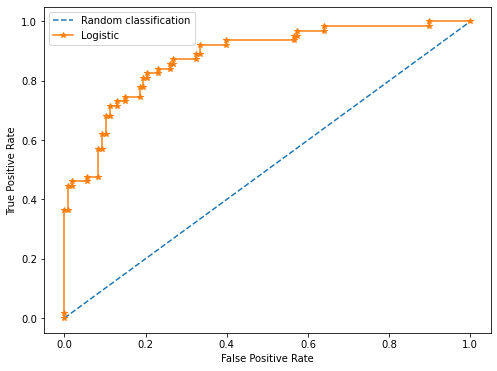

In [30]:
prob_test = pd.DataFrame(model_LR_rus.predict_proba(X_test))
prob_test = prob_test[1]

# generate a no skill prediction (majority class)
random_class = [0 for _ in range(len(y_test))]
rand_auc = roc_auc_score(y_test, random_class)

auc = roc_auc_score(y_test, prob_test)
print('Logistic: ROC AUC=%.3f' % (auc))

rndm_false_postv, rndm_true_postv, threshold = roc_curve(y_test, random_class)
false_positive, true_postitive, _ = roc_curve(y_test, prob_test)

plt.figure(figsize=(8, 6))
plt.plot(rndm_false_postv, rndm_true_postv, linestyle='--', label='Random classification')
plt.plot(false_positive, true_postitive, marker='*', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Definición del punto de corte (threshold)

In [34]:
def Threshold(X = X_test, model = model_LR_rus, threshold = 0.5):
    prob_test = pd.DataFrame(model.predict_proba(X).round(3))
    
    prob_test.loc[prob_test[1] > threshold, 'yhat'] = 1
    prob_test.loc[prob_test[1] <= threshold, 'yhat'] = 0
    
    y_threshold = pd.concat([prob_test, y_test.reset_index(drop = True)], axis = 1)
    cross_threshold = pd.crosstab(y_threshold["diagnosis2"], y_threshold["yhat"], margins = True)
    
    print(tabulate(cross_threshold,headers = ['pred No','Pred Yes', 'All'], showindex = ['Real No','Real Yes', 'All'], tablefmt = 'fancy_grid'))
    
    accuracy = (cross_threshold[1][1] + cross_threshold[0][0]) / (cross_threshold['All']['All'])
    recall = cross_threshold[1][1] / (cross_threshold[1][1] + cross_threshold[0][1])
    precision = cross_threshold[1][1] / (cross_threshold[1][1] + cross_threshold[1][0])
    F_Score = 2*(precision*recall) / (precision + recall)
    print("\n")
    print("Accuracy", accuracy.round(3))
    print("Precision", precision.round(3))
    print("Recall", recall.round(3))
    print("F_Score", F_Score.round(3))
    print("\n")
    #return cross_threshold

Threshold(X_test,model_LR_rus, 0.50)

╒══════════╤═══════════╤════════════╤═══════╕
│          │   pred No │   Pred Yes │   All │
╞══════════╪═══════════╪════════════╪═══════╡
│ Real No  │        89 │         19 │   108 │
├──────────┼───────────┼────────────┼───────┤
│ Real Yes │        16 │         47 │    63 │
├──────────┼───────────┼────────────┼───────┤
│ All      │       105 │         66 │   171 │
╘══════════╧═══════════╧════════════╧═══════╛


Accuracy 0.795
Precision 0.712
Recall 0.746
F_Score 0.729




In [35]:
Threshold(X_test,model_LR_rus, 0.55)

╒══════════╤═══════════╤════════════╤═══════╕
│          │   pred No │   Pred Yes │   All │
╞══════════╪═══════════╪════════════╪═══════╡
│ Real No  │       107 │          1 │   108 │
├──────────┼───────────┼────────────┼───────┤
│ Real Yes │        40 │         23 │    63 │
├──────────┼───────────┼────────────┼───────┤
│ All      │       147 │         24 │   171 │
╘══════════╧═══════════╧════════════╧═══════╛


Accuracy 0.76
Precision 0.958
Recall 0.365
F_Score 0.529




In [36]:
Threshold(X_test,model_LR_rus, 0.45)

╒══════════╤═══════════╤════════════╤═══════╕
│          │   pred No │   Pred Yes │   All │
╞══════════╪═══════════╪════════════╪═══════╡
│ Real No  │        33 │         75 │   108 │
├──────────┼───────────┼────────────┼───────┤
│ Real Yes │         1 │         62 │    63 │
├──────────┼───────────┼────────────┼───────┤
│ All      │        34 │        137 │   171 │
╘══════════╧═══════════╧════════════╧═══════╛


Accuracy 0.556
Precision 0.453
Recall 0.984
F_Score 0.62


